In [44]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import matlab.engine
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import as_completed
import pandas as pd
import os.path
from shutil import copyfile
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance_matrix
from data_managment import *
from globals import *

In [45]:
#run time configurations
num_workers = 4
create_amount = 200
batch_size = 20
IMG_X = 1001
IMG_Y = 300
depth = 40e-3
dz = (80e-3 - 10e-3)/IMG_Y
SEQ_LENGTH = 50
device = 'cuda' if torch.cuda.is_available() else 'cpu'
out_size = 128 
path_combined = "C:/Users/drors/Desktop/code for thesis/data advanced.csv"

In [46]:
eng = []
for i in range(num_workers):
    eng.append(matlab.engine.start_matlab())
    eng[i].init_field(nargout=0)


In [47]:
def extract_line(depth,dz,im):
    return im[:,(depth-10e-3)/dz,:]



In [48]:
def create_lines(eng,delays):
    delays = torch.reshape(delays,(-1,2 * 128))
    (delays, amps) = torch.split(delays,128,1)
    #print(amps.shape,delays.shape)
    batch_size = delays.shape[0]
    batch = np.zeros((batch_size,IMG_X))
    for i in range(batch_size):
        delay = matlab.double(delays[i].tolist())
        amp = matlab.double(amps[i].tolist())
        batch[i,:] = np.asarray(eng.create_new_line(delay,amp))
    return batch



In [49]:
def create_images(eng,delays):
    delays = torch.reshape(delays,(-1,2 * 128))
    (delays, amps) = torch.split(delays,128,1)
    batch_size = delays.shape[0]
    batch = np.zeros((batch_size,IMG_Y, IMG_X))
    for i in range(batch_size):
        delay = matlab.double(delays[i].tolist())
        amp = matlab.double(amps[i].tolist())
        batch[i,:,:] = np.asarray(eng.create_new_image(delay,amp))
    # delays = matlab.double(delays.tolist())
    # amps = matlab.double(amps.tolist())
    # batch  = eng.create_new_image(delays,amps)
    return batch



In [50]:
def check_minimal_distance(a,b,minimal):
    if isinstance(a,list):
        for loc in a:
            if abs(loc - b) < minimal:
                return False
        return True
    else:
        if a == 0:
            return True
        return abs(a - b) > minimal



In [51]:
def create_patterns_1d(amount,N,seq_length = 50):
    patterns = np.zeros((amount,N))
    number_in_each = np.random.randint(1,3,amount)
    dx = (15e-3 + 15e-3)/N
    c = 1490
    f0 = 4.464e6
    D = 0.218e-3 * 128
    minimal_distance = (1.206 * (c/f0) * 40e-3) / D
    minimum = minimal_distance / dx
    f = np.vectorize(check_minimal_distance)
    #x = np.arange(-10*minimal_distance,10*minimal_distance,dx)
    x = np.linspace(-30e-3,30e-3,N * 2)
    sinc = np.sinc(1045.61 * x) #number computed numerically for the width of the sinc
    #sinc = np.sinc()
    sinc_len = len(sinc)
    for i in range(amount):
        j = 0
        actual = []
        while j < number_in_each[i]:
            point = np.random.randint(0,N,1)
            val = point[0]
            if check_minimal_distance(actual,point,minimum):
                actual.append(val)
                j += 1
        #patterns[i,positions] = 1
        for position in actual:
            shifted_sinc = np.roll(sinc,position - 100)
            patterns[i,:] += shifted_sinc[round(N/2):round(3*N/2)]
            #position = positions[k,0]
            #lower = max(0,position - round(sinc_len/2))
            #upper = min(IMG_X,position+round(sinc_len/2) - 1)
            #actual_len = upper - lower + 1
            #print(lower,upper,actual_len)
            #if lower == 0:
            #    to_apply = sinc[-actual_len:]
            #elif upper == IMG_X:
            #      to_apply = sinc[:actual_len - 1]
            #else:
            #      to_apply = sinc
            #patterns[i,lower:upper] += to_apply
    return torch.from_numpy(patterns)



In [65]:
class baseDataSet(Dataset):
    def __init__(self,indexes,source_data,seq_length = 50 ,csv_file = "C:/Users/drors/Desktop/code for thesis/data.csv",transforms = None, mode = 'both'):
        #self.data = pd.read_csv(csv_file,header = None, index_col = 0,skiprows = )
        self.data = source_data.iloc[indexes,:].copy()
        self.csv = csv_file
        self.measure = nn.CosineSimilarity()
        self.seq_length = seq_length
        self.mode = mode
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        if self.mode == 'both':
            x = self.data.iloc[idx,:IMG_X]
            y = pd.concat([self.data.iloc[idx,IMG_X:IMG_X + 128] * 1e5,self.data.iloc[idx,IMG_X+128:]], axis = 0)
        else:
            x = self.data.iloc[idx,:IMG_X]
            y = self.data.iloc[idx,IMG_X:]
        # if len(y) == 2 * 128:
        #     y = torch.tensor(y.values).split(128,1)
        # else:
        #     y = torch.tensor(y.values)
        return torch.tensor(x.values).reshape(-1,self.seq_length),torch.tensor(y.values)
    def test_get(self,idx):
        x = self.data.iloc[idx,:IMG_X]
        y = pd.concat([self.data.iloc[idx,IMG_X:IMG_X + 128] * 1e5,self.data.iloc[idx,IMG_X+128:]], axis = 0)
        return torch.tensor(x.values).reshape(-1,self.seq_length),torch.tensor(y.values)
    def get_data(self):
        return self.data
    def add_batch(self,new_data):
        #similarity = cosine_similarity(new_data,self.data)
        distance = distance_matrix(new_data.iloc[:,:IMG_X],self.data.iloc[:,:IMG_X])
        mask = np.all(distance > 1e-2, axis = 1)

        #print(new_data.shape,self.data.shape,similarity.shape,mask.shape)
        new_data = new_data.loc[mask,:]
        #new_df = pd.DataFrame(new_data,header = None)
        self.data = self.data.append(new_data,ignore_index = True)
        if len(self.data) > 10000:
            self.data = self.data.iloc[len(self.data) - 10000:,:]
            #self.data = pd.concat([self.data.iloc[:50,:],self.data.iloc[(len(self.data) - 1000):,:]]) 
        #new_df.to_csv(self.csv,mode = 'a', header = None)



In [66]:
class datasetManager():
    def __init__(self,eng,seq_length = 50,csv_file = "C:/Users/drors/Desktop/code for thesis/data.csv",orig = "C:/Users/drors/Desktop/code for thesis/data original.csv"):
        self.eng = eng
        self.csv_file = csv_file
        if orig == path_combined:
            self.mode = 'both'
        else:
            self.mode = 'single'
        self.orig = orig
        self.train,self.val,self.test = self.create_datasets()
        self.seq_length = seq_length
        
    def create_datasets(self):
        data = pd.read_csv(self.orig,header = None,index_col = None, engine = 'python')
        n = len(data)
        perm = np.random.permutation(n)
        train_idx = perm[:round(0.8*n)]
        val_idx = perm[round(0.8*n):round(0.9*n)]
        test_idx = perm[round(0.9*n):]
        train_dataset = baseDataSet(train_idx,data,mode = self.mode)
        val_dataset = baseDataSet(val_idx,data,mode = self.mode)
        test_dataset = baseDataSet(test_idx,data,mode = self.mode)
        return train_dataset,val_dataset,test_dataset
    def get_datasets(self):
        return self.train,self.val,self.test
    def reset(self):
        data = pd.read_csv(self.orig,header = None,index_col = None, engine = 'python')
        n = len(data)
        perm = np.random.permutation(n)
        train_idx = perm[:round(0.8*n)]
        val_idx = perm[round(0.8*n):round(0.9*n)]
        test_idx = perm[round(0.9*n):]
        train_dataset = baseDataSet(train_idx,data,mode = self.mode)
        val_dataset = baseDataSet(val_idx,data,mode = self.mode)
        test_dataset = baseDataSet(test_idx,data,mode = self.mode)
        self.train,self.val,self.test =  train_dataset,val_dataset,test_dataset
        copyfile(self.orig,self.csv_file)
        
    def add_batch_to_data(self,batch, mode = 'create'):
        new_df = pd.DataFrame(batch).astype('float')
        n = len(new_df)
        perm = np.random.permutation(n)
        train_idx = perm[:round(0.8*n)]
        val_idx = perm[round(0.8*n):round(0.9*n)]
        test_idx = perm[round(0.9*n):]
        if mode == 'create':
            self.train = baseDataSet(train_idx,new_df) # .add_batch(new_df.iloc[train_idx,:])
            self.val = baseDataSet(val_idx,new_df)# .add_batch(new_df.iloc[val_idx,:])
            self.test = baseDataSet(test_idx,new_df)# .add_batch(new_df.iloc[test_idx,:])
            new_df.to_csv(self.csv_file, header = None,index = False)
        else:
            self.train.add_batch(new_df.iloc[train_idx,:])
            self.val.add_batch(new_df.iloc[val_idx,:])
            self.test.add_batch(new_df.iloc[test_idx,:])
            new_df.to_csv(self.csv_file,mode = 'a', header = None,index = False)
    def generate_base_dataset(self,amount = create_amount, mode = 'create'):
        amount *= 5
        delays = torch.rand(amount,128) * 1e-5
        delays = torch.cat(delays,torch.ones(amount,128),1)
        with ThreadPoolExecutor() as executor:
            new_delay = torch.reshape(delays,(len(self.eng),-1))
            new_delay = new_delay
            results = executor.map(create_lines,self.eng,new_delay)
        res = np.zeros((amount,IMG_X))
        size_eng = amount / len(self.eng)
        for i,line in enumerate(results):
            res[round(size_eng * i):round(size_eng *(i+1)),:] = line
#        print(np.fromiter(results,matlab.double))
        self.add_batch_to_data(torch.cat((torch.tensor(res),delays),1),mode)
        torch.cat((torch.tensor(res),delays),1)
        
    def create_batch(self,net,amount = create_amount):
        patterns = create_patterns_1d(amount,IMG_X)
        net.eval()
        if isinstance(net,lstmModel):
            h = net.init_hidden(amount)
            patterns_to_send = patterns.reshape(amount,-1,self.seq_length)
            delays,_ = net(patterns_to_send.float(),h)
        else:
            #patterns_to_send = patterns.reshape(amount,-1,self.seq_length)
            delays = net(patterns.float())
        
        delays[:,:128] *= 1e-5
        #while np.any(delays.detach().numpy() > 1e-5):
        #    delays *= 1e-1
        if torch.any(torch.isnan(delays)):
            print(delays)
        with ThreadPoolExecutor() as executor:
            new_delay = torch.reshape(delays,(num_workers,-1))
            results = executor.map(create_lines,self.eng,new_delay)
        res = np.zeros((amount,IMG_X))
        size_eng = amount / len(self.eng)
        for i,line in enumerate(results):
            res[round(size_eng * i):round(size_eng *(i+1)),:] = line
#        print(np.fromiter(results,matlab.double))
        return torch.from_numpy(res),delays,patterns

    def create_pressure_batch(self,delays,amount = 8):
        with ThreadPoolExecutor() as executor:
            #delays = delays * 1e-5
            new_delay = torch.reshape(delays,(num_workers,-1))
            results = executor.map(create_images,self.eng,new_delay)
        res = np.zeros((amount,IMG_Y,IMG_X))
        size_eng = amount / len(self.eng)
        for i,line in enumerate(results):
            res[round(size_eng * i):round(size_eng *(i+1)),:,:] = line
        return res



In [67]:
def test_batch(net,data_manager,amount = 8):
    results,delays,orig_patterns = data_manager.create_batch(net,amount)
    images = data_manager.create_pressure_batch(delays)
    x = np.linspace(-15e-3,15e-3,IMG_X)

    z = np.linspace(10e-3,80e-3,300)
    if amount == 4:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10,5))
        ax2.plot(x *1e3,results[0,:])
        ax2.set_title('result from net')
        ax1.plot(x *1e3,orig_patterns[0,:])
        ax1.set_title('expected')
        ax3.imshow(np.rot90(images[0,:,:],4),cmap = 'hot',extent = [-15,15,80,10])
    else:
        for i in range(amount):
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,5))
            ax2.plot(x *1e3,results[i,:])
            ax2.set_title('result from net')
            ax1.plot(x *1e3,orig_patterns[i,:])
            ax1.set_title('expected')
            ax3.imshow(np.rot90(images[i,:,:],4),cmap = 'hot',extent = [-15,15,80,10])


In [68]:
#dataManager = datasetManager(eng,orig=path_combined)
dataManager = datasetManager(eng)


In [56]:
def init_weights(m):
    for name in m.named_parameters():
        if 'weight' in name[0]:
            torch.nn.init.uniform_(name[1], a=-0.1, b=0.1)
        elif 'bias' in name[0]:
            torch.nn.init.zeros_(name[1])

In [57]:
class lstmModel(nn.Module):
    def __init__(self,drop = 0.6,in_size = IMG_X,out_size = 2 * 128, n_layers = 2,seq_length = 50):
        super(lstmModel,self).__init__()
        self.in_size = seq_length
        self.out_size = out_size
        self.n_layers = n_layers
        self.hidden_size = 2 * out_size
        self.seq_length = seq_length
        self.norm = nn.BatchNorm1d(in_size)
        self.rnn = nn.LSTM(self.in_size, self.hidden_size, n_layers,
                           dropout = drop, batch_first=True, bidirectional = True)
        self.dropout = nn.Dropout(drop)
        self.fc = nn.Sequential(nn.Linear(self.hidden_size,round(1.5 * out_size)),
                                nn.Dropout(drop),
                                nn.LeakyReLU(),
                                nn.Linear(round(1.5 * out_size),round(1.25 * out_size)),
                                nn.Dropout(drop),
                                nn.LeakyReLU(),
                                nn.Linear(round(1.25 * out_size),out_size))
        self.fc2 = nn.Linear(self.hidden_size,out_size)
        self.apply(init_weights)
    def forward(self,x,hidden):
        batch_size = x.size(0)
        seq_num = x.size(1)
        x = x.reshape(batch_size,-1)
        out = self.norm(x).reshape(batch_size,seq_num,-1)
        out = self.dropout(out)
        out,hidden = self.rnn(out,hidden)
        out = out.contiguous().view(-1, 2 * self.out_size)
        out = self.dropout(out)
        out = self.fc(out)
        out = out.view(batch_size,-1)
        out = out[:,-2 * self.out_size:]
        out = self.fc2(out)
        #out = out * -1e-5
        return out, hidden
    
    def init_hidden(self,batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers * 2, batch_size,2 * self.out_size).zero_().to(device),
                      weight.new(self.n_layers * 2, batch_size,2 * self.out_size).zero_().to(device))
        return hidden
 #   def init_weights(m):
 #       for name in m.named_parameters():
 #           if 'weight' in name[0]:
 #               torch.nn.init.uniform_(name[1], a=-0.1, b=0.1)
 #           elif 'bias' in name[0]:
 #               torch.nn.init.zeros_(name[1])
        



In [58]:
def trainLstm(net,opt,dataManager,schedular,n_epochs = 30,batch_size = 40):
    datasets = dataManager.get_datasets()
    train = DataLoader(datasets[0],batch_size = batch_size, shuffle = True, drop_last = True)
    val = DataLoader(datasets[1],batch_size = batch_size, shuffle = True, drop_last = True)
    test = DataLoader(datasets[2],batch_size = batch_size, shuffle = True, drop_last = True)
    net.to(device)
    train_loss_total = []
    val_loss_total = []
    test_loss_total = []
    #criterion = nn.L1Loss() #will probably have outliers, L1 is more robust
    criterion = nn.MSELoss()
    #criterion = nn.CosineSimilarity()
    for i in range(n_epochs):
        training_loss = 0
        val_loss = 0
        net.train()
        h = net.init_hidden(batch_size)
        for x,y in train:
            h = tuple([e.data for e in h])
            x.to(device),y.to(device)
            opt.zero_grad()
            output, h  = net(x.float(),h)
            loss = criterion(output,y.float())
            loss.mean().backward()
            training_loss += loss.mean().item()
            #nn.utils.clip_grad_norm_(net.parameters(), 1) 
            opt.step()
        with torch.no_grad():
            net.eval()
            h = net.init_hidden(batch_size)
            for x,y in val:
                h = tuple([e.data for e in h])
                x.to(device),y.to(device)
                output, h  = net(x.float(),h)
                loss = criterion(output,y.float())
                val_loss += loss.mean().item()
        training_loss = training_loss / len(train)
        if len(val) == 0:
            val_loss = 'no values'
        else:
            val_loss = val_loss / len(val)
        print(f'epoch num: {i}, train loss: {training_loss}, validation loss:{val_loss}, length of train {len(train) * batch_size}')
        schedular.step()
        if i % 3 == 0:
            print(f'testing at epoch num: {i}')
            test_batch_delays(net,dataManager)
            test_batch(net,dataManager)
            # for name, param in net.named_parameters():
            #     if param.requires_grad:
            #         print (name, torch.mean(param.data))
        #results,delays,orig_patterns = dataManager.create_batch(net,amount = 500)
        #dataManager.add_batch_to_data(torch.cat((results,delays),1), mode = 'add')



In [59]:
class basic_model(nn.Module):

    def __init__(self,in_size = IMG_X,out_size = 2 * 128,drop = 0.2):
        super(basic_model, self).__init__()
        self.drop = drop
        self.fc1 = nn.Sequential(nn.BatchNorm1d(in_size),
                                 nn.Linear(in_size,in_size),
                                #nn.BatchNorm1d(180),
                                nn.Dropout(p=drop),
                                #nn.ReLU(),
                                #nn.Linear(180,150),
                                #nn.BatchNorm1d(150),
                                #nn.Dropout(p=0.2),
                                nn.ReLU())
        self.fc2 = nn.Linear(in_size,out_size)
        self.apply(init_weights)
    def forward(self,x):
        batch_size = x.size(0)
        x = x.reshape(batch_size,-1)
        out = self.fc1(x)
        out = self.fc2(out)

        #out = out *-1e-5
        return out



In [60]:
class cnn_model(nn.Module):
    def __init__(self,in_size = IMG_X,out_size = 2 * 128,drop = 0.2):
        super(cnn_model, self).__init__()
        self.drop = drop
        self.block1 = nn.Sequential(nn.Conv1d(1,3,3),
                                    nn.ReLU())
        self.block2 = nn.Sequential(nn.Conv1d(3,6,3),
                                    nn.ReLU())
        #self.block3 = nn.Sequential(nn.Conv1d(6,16,3),
        #                            nn.ReLU())
        # self.fc1 = nn.Sequential(nn.Linear((in_size - 4) * 16, in_size * 8),
        #                             nn.ReLU(),
        #                             nn.Dropout(drop),
        #                             nn.Linear(in_size * 8, in_size * 4),
        #                             nn.ReLU(),
        #                             nn.Dropout(drop))
        self.fc1 = nn.Sequential(nn.Linear((in_size - 4) * 6, in_size * 4),
                                    nn.ReLU(),
                                    nn.Dropout(drop))
        self.fc_delays = nn.Sequential(nn.Linear(in_size * 4,in_size * 2),
                                    nn.ReLU(),
                                    nn.Dropout(drop),
                                    nn.Linear(in_size * 2,round(out_size/2)))
        self.fc_amp = nn.Sequential(nn.Linear(in_size * 4,in_size * 2),
                                    nn.ReLU(),
                                    nn.Dropout(drop),
                                    nn.Linear(in_size * 2,round(out_size/2)))

        self.apply(init_weights)
    def forward(self,x):
        batch_size = x.size(0)
        x = x.reshape(batch_size,1,-1)
        out = self.block1(x)
        #print(out.shape)
        out = self.block2(out)
        #print(out.shape)
        #out = self.block3(out)
        out = out.reshape(batch_size,-1)
        out = self.fc1(out)
        out1 = self.fc_delays(out)
        out2 = self.fc_amp(out)
        #out = out *-1e-5
        return torch.cat((out1,out2), dim = 1)


In [61]:
def test_batch_delays(net,data_manager,amount = 8):
    datasets = dataManager.get_datasets()
    test = DataLoader(datasets[2],batch_size = batch_size, shuffle = True, drop_last = True)
    patterns = torch.zeros((amount,IMG_X))
    ground = torch.zeros((amount,256))
    delays = np.zeros((amount,256))
    res = np.zeros((amount,IMG_X))
    width = 0.218e-3 * 128
    delay_x = np.linspace(-width/2,width/2,128)
    x_line = np.linspace(-15e-3,15e-3,IMG_X)
    z = np.linspace(10e-3,80e-3,300)
    seq_length = SEQ_LENGTH

    i = 0

    for x,y in test:
        if i >= amount:
            break
        amount_added = x.size(0)
        seq_length = x.size(2)
        if i + amount_added > amount:
            x = x[:amount - i]
            y = y[:amount - i] 
            amount_added = amount - i
        net.eval()
        patterns[i:i+amount_added,:] = x.reshape(-1,IMG_X)
        ground[i:i+amount_added,:] = y
        i += amount_added        
    if isinstance(net,lstmModel):
        h = net.init_hidden(amount)
        to_send = patterns.reshape((amount,-1,seq_length))
        delays, h  = net(to_send.float(),h)
    else:
            #patterns_to_send = patterns.reshape(amount,-1,self.seq_length)
        delays = net(patterns.float())
    delays[:,:128] *= 1e-5
    with ThreadPoolExecutor() as executor:
        new_delay = torch.reshape(delays,(len(eng),-1))
        results = executor.map(create_lines,eng,new_delay)
    size_eng = amount / len(eng)
    for i,line in enumerate(results):
        res[round(size_eng * i):round(size_eng *(i+1)),:] = line
    images = data_manager.create_pressure_batch(delays)
    delays[:,:128] *= 1e5
    for i in range(amount):
        fig, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, figsize = (15,5))
        ax1.plot(x_line *1e3,res[i,:], label = 'from net')
        ax1.plot(x_line *1e3,patterns.cpu().detach().numpy()[i,:], label = 'ground')
        ax1.set_title('at image plane')
        ax1.legend()
        ax3.imshow(np.rot90(images[i,:,:],4),cmap = 'hot',extent = [-15,15,80,10])
        ax2.plot(delay_x,delays.cpu().detach().numpy()[i,:128], label = 'from net')
        ax2.plot(delay_x,ground.cpu().detach().numpy()[i,:128], label = 'ground')
        ax2.set_title('delays')
        ax2.legend()
        ax4.plot(delay_x,delays.cpu().detach().numpy()[i,128:], label = 'from net')
        ax4.plot(delay_x,ground.cpu().detach().numpy()[i,128:], label = 'ground')
        ax4.set_title('amplitudes')
        ax4.legend()


In [62]:
def trainModel(net,opt,dataManager,schedular,n_epochs = 30,batch_size = 20):
    datasets = dataManager.get_datasets()
    train = DataLoader(datasets[0],batch_size = batch_size, shuffle = True, drop_last = True)
    val = DataLoader(datasets[1],batch_size = batch_size, shuffle = True, drop_last = True)
    test = DataLoader(datasets[2],batch_size = batch_size, shuffle = True, drop_last = True)
    net.to(device)
    train_loss_total = []
    val_loss_total = []
    test_loss_total = []
    criterion = nn.MSELoss()
    #criterion = nn.L1Loss() #will probably have outliers, L1 is more robust
    #criterion = nn.CosineSimilarity()
    for i in range(n_epochs):
        training_loss = 0
        val_loss = 0
        net.train()
        for x,y in train:
            x.to(device),y.to(device)
            opt.zero_grad()
            output = net(x.float())
            loss = criterion(output,y.float())
            loss.mean().backward()
            training_loss += loss.mean().item()
            opt.step()
        with torch.no_grad():
            net.eval()
            for x,y in val:
                x.to(device),y.to(device)
                output = net(x.float())
                loss = criterion(output,y.float())
                val_loss += loss.mean().item()
        training_loss = training_loss / len(train)
        if len(val) == 0:
            val_loss = 'no values'
        else:
            val_loss = val_loss / len(val)
        print(f'epoch num: {i}, train loss: {training_loss}, validation loss:{val_loss}, length of train {len(train) * batch_size}')
        schedular.step()
        if i % 3 == 0:
            print(f'testing at epoch num: {i}')
            test_batch_delays(net,dataManager)
            test_batch(net,dataManager)
            # for name, param in net.named_parameters():
            #     if param.requires_grad:
            #         print (name, torch.mean(param.data))
#        results,delays,orig_patterns = dataManager.create_batch(net,amount = 500)
#        dataManager.add_batch_to_data(torch.cat((results,delays),1), mode = 'add')
 #       dataManager.generate_base_dataset(mode = 'add')
#        if i%3 == 0:
#            print(f'testing iteration number: {i}')
#            test_batch(net,dataManager,amount = 4)



In [63]:
dataManager.reset()
# dataManager.get_datasets()[0].test_get(10)
#dataManager.generate_base_dataset()
#dataManager.generate_base_dataset(mode = 'add')
#dataManager.generate_base_dataset(mode = 'add')
#dataManager.generate_base_dataset(mode = 'add')
#dataManager.generate_base_dataset(mode = 'add')



In [69]:
net = cnn_model(drop = 0.2)
optimizer = optim.SGD(net.parameters(),lr = 1, momentum = 0.95, weight_decay = 1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
dataManager.reset()
trainModel(net,optimizer,dataManager,scheduler,n_epochs = 1)
test_batch_delays(net,dataManager)
test_batch(net,dataManager)



C:\Users\drors\miniconda3\envs\thesis\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 128])) that is different to the input size (torch.Size([20, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (256) must match the size of tensor b (128) at non-singleton dimension 1

epoch num: 0, train loss: 0.2932087355852127, validation loss:0.19445560003320375, length of train 4000
testing at epoch num: 0
epoch num: 1, train loss: 0.17581747576594353, validation loss:0.15535677348574004, length of train 4000
epoch num: 2, train loss: 0.1623547486960888, validation loss:0.1538936917980512, length of train 4000


KeyboardInterrupt: 

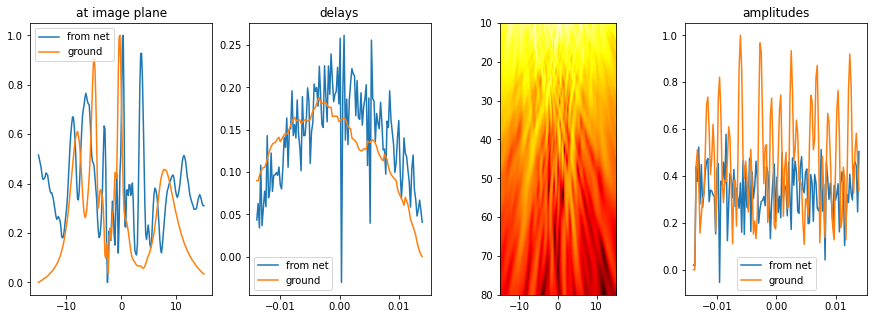

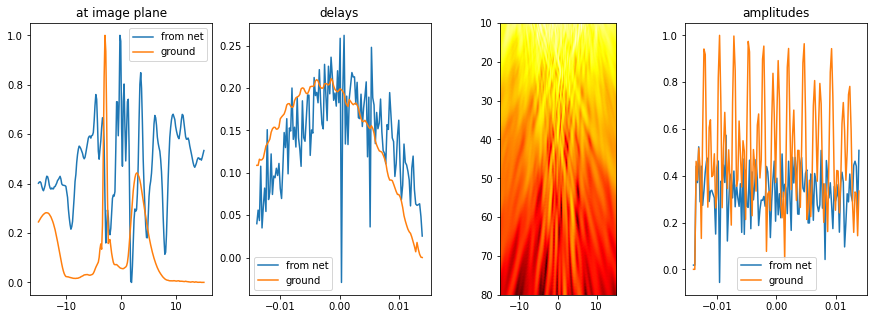

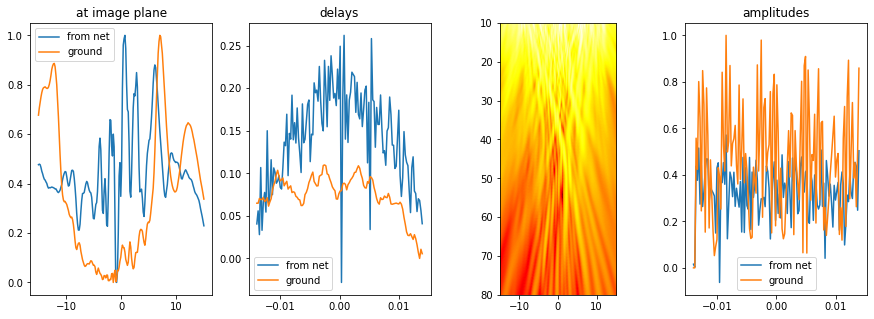

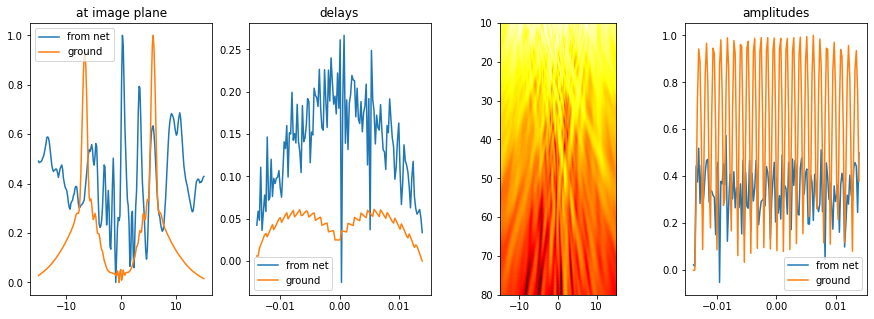

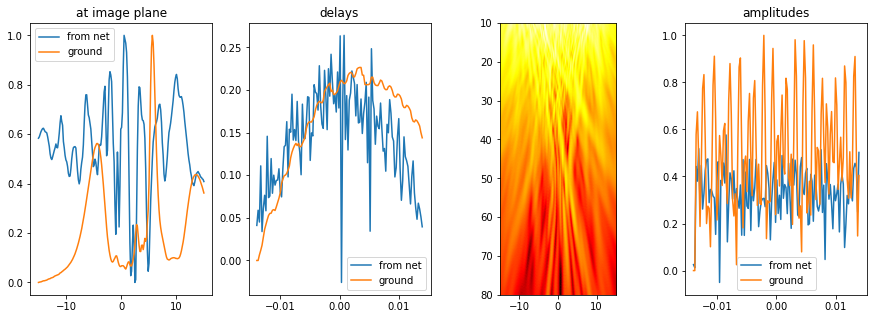

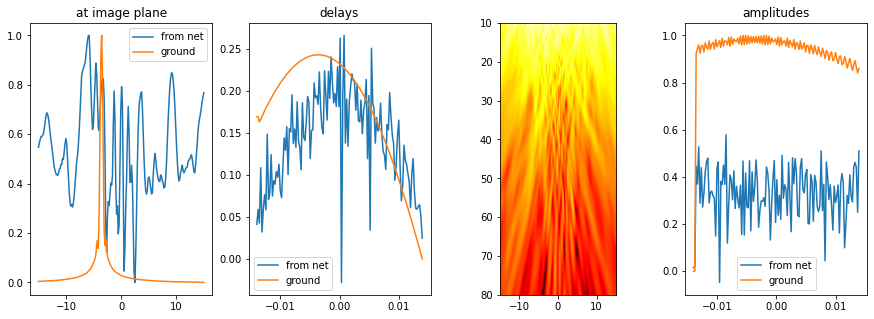

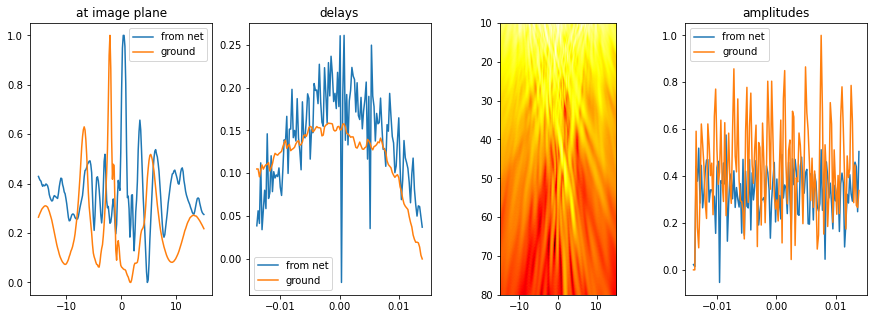

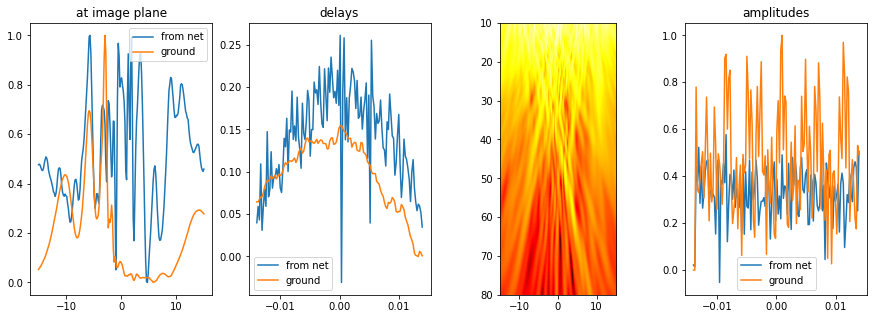

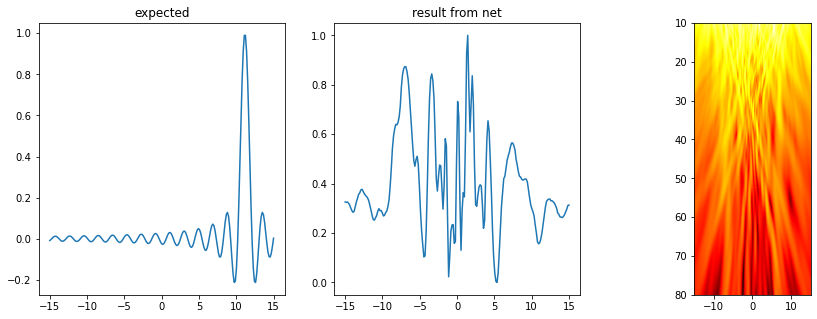

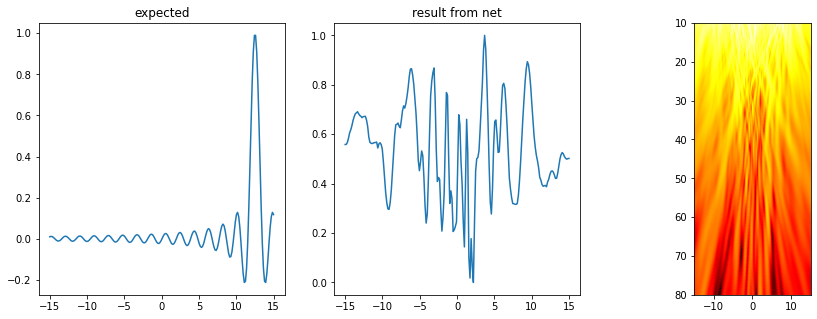

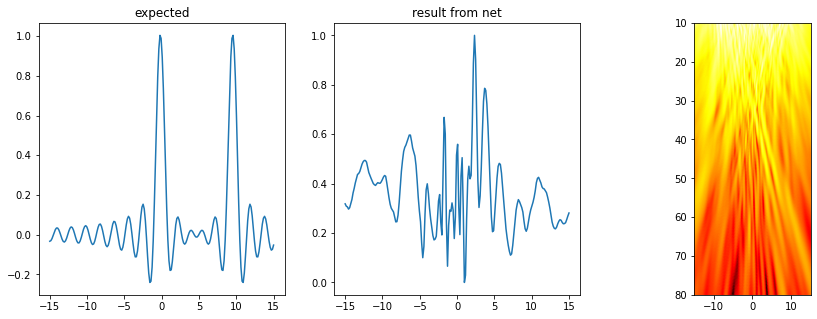

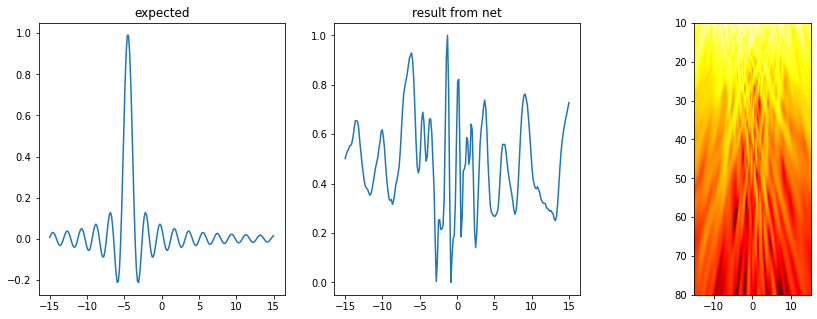

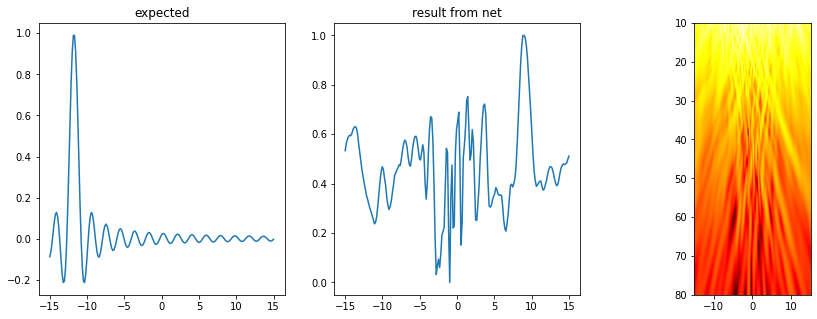

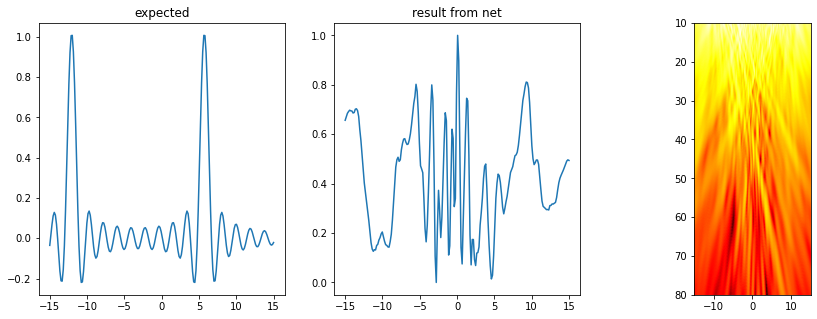

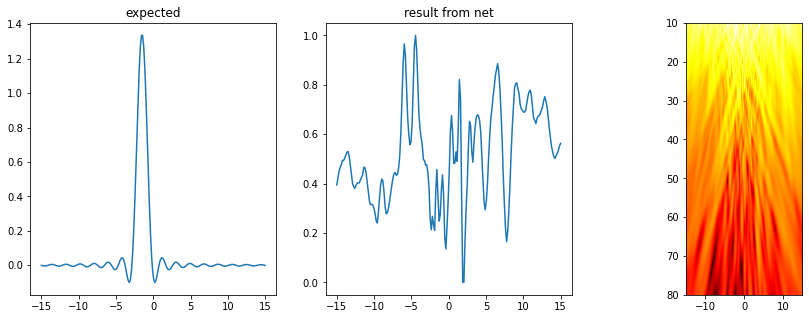

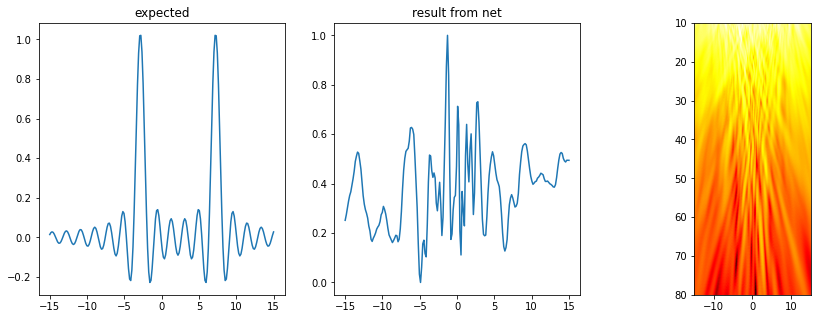

In [28]:
net = lstmModel(n_layers = 2, drop = 0.4)
optimizer = optim.SGD(net.parameters(),lr = 0.01, momentum = 0.95, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
dataManager.reset()
trainLstm(net,optimizer,dataManager,scheduler,n_epochs = 10)
test_batch_delays(net,dataManager)
test_batch(net,dataManager)


In [21]:
net = lstmModel(n_layers = 2, drop = 0.8)
optimizer = optim.SGD(net.parameters(),lr = 0.1, momentum = 0.95, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.75)
dataManager.reset()
trainLstm(net,optimizer,dataManager,scheduler,n_epochs = 20)
test_batch_delays(net,dataManager)
test_batch(net,dataManager)


TypeError: new() received an invalid combination of arguments - got (float, int), but expected one of:
 * (*, torch.device device)
      didn't match because some of the arguments have invalid types: (!float!, !int!)
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, *, torch.device device)
 * (object data, *, torch.device device)


In [ ]:
print(net.fc1[0].weight,net.fc1[0].bias)



In [ ]:
net = basic_model(drop = 0.6)
print('trying to create new batch')
results,delays,orig_patterns = dataManager.create_batch(net)
print('created new batch, trying to add to data')
dataManager.add_batch_to_data(torch.cat((results,delays),1))



20


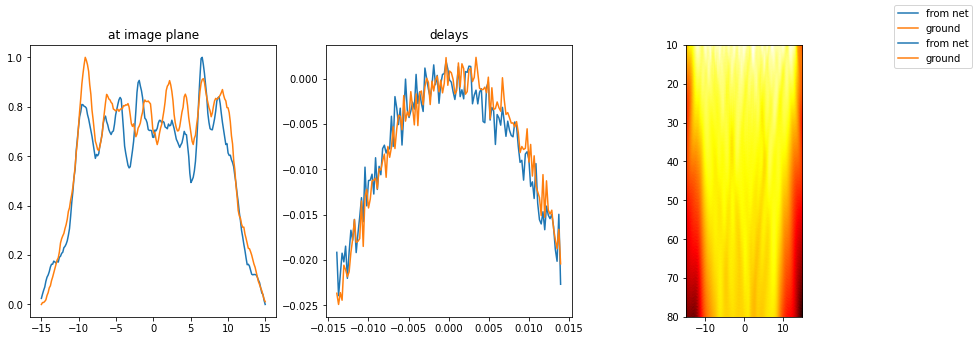

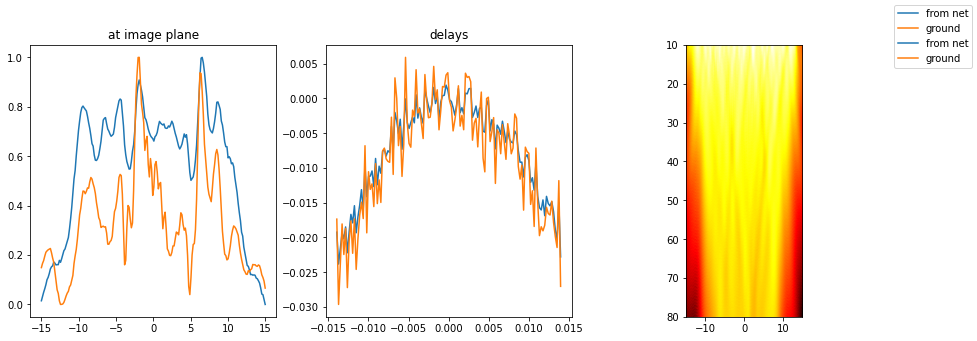

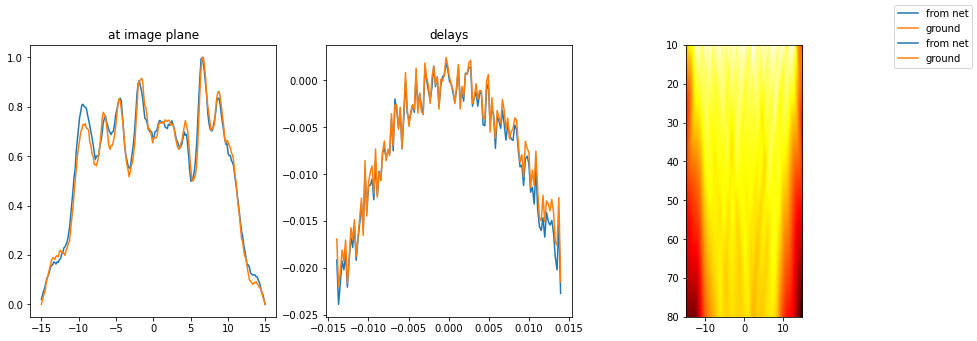

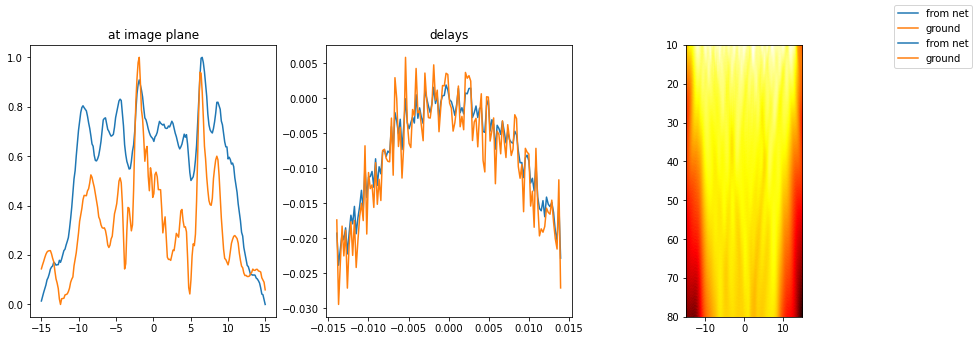

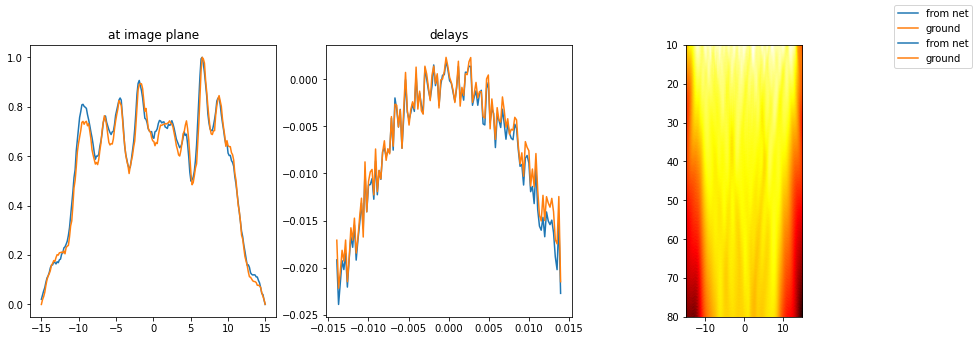

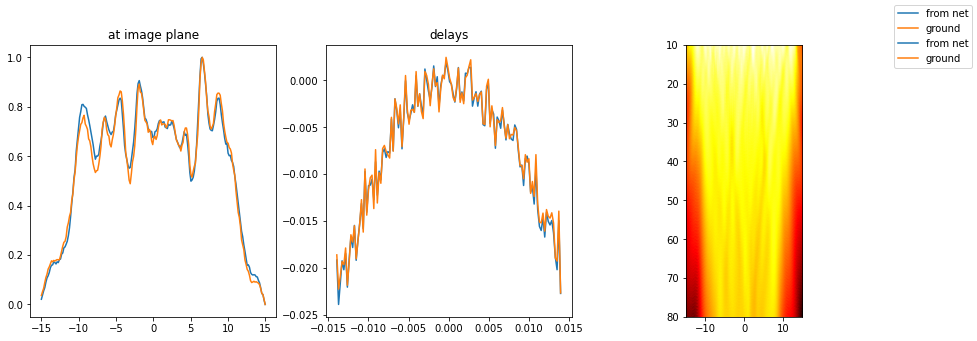

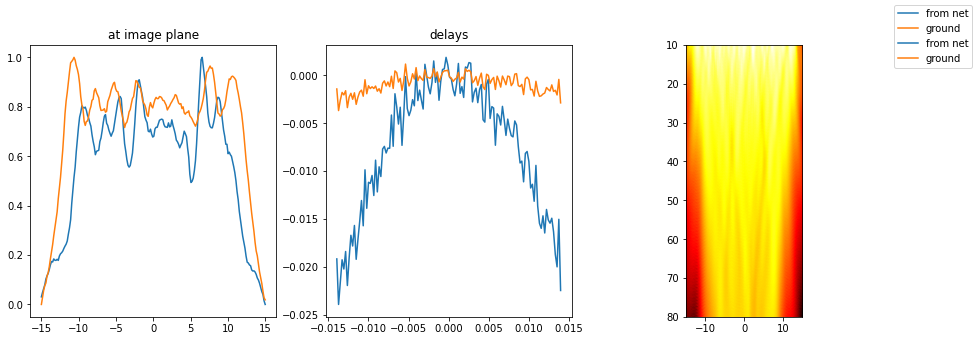

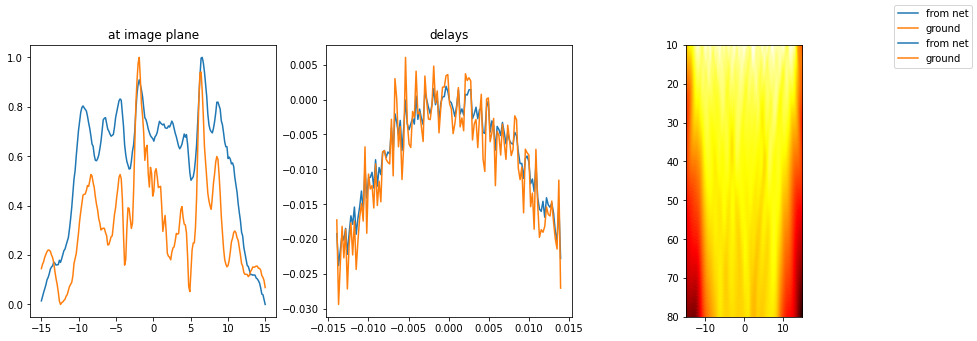

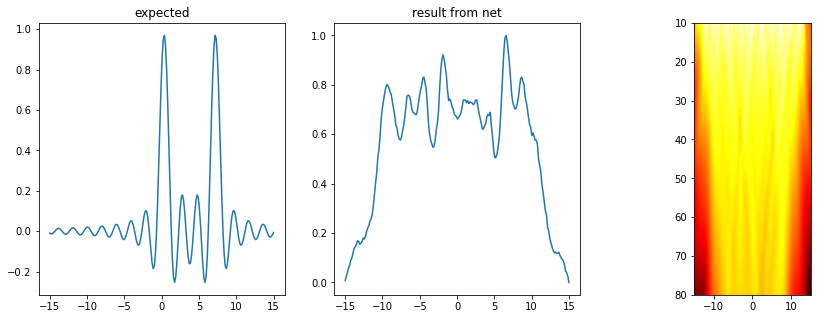

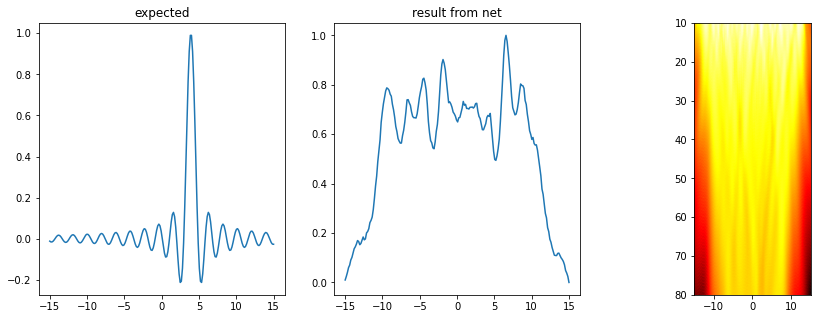

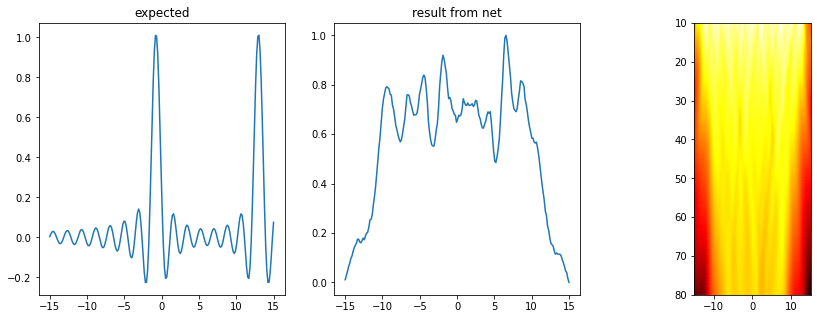

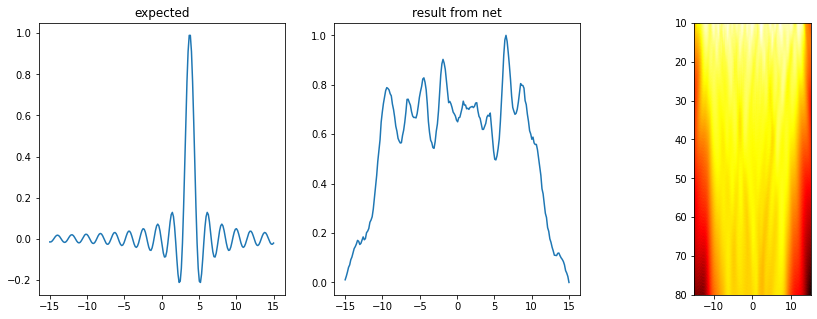

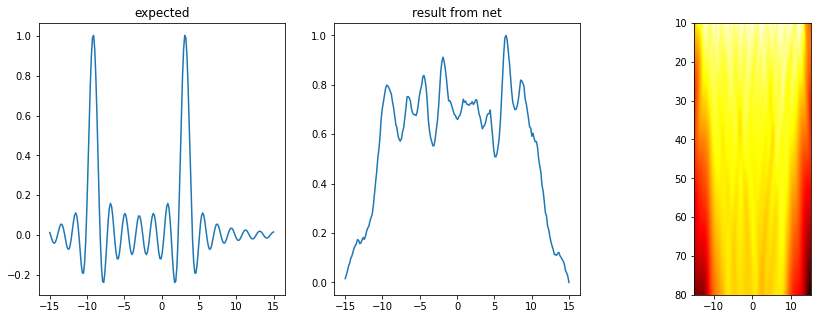

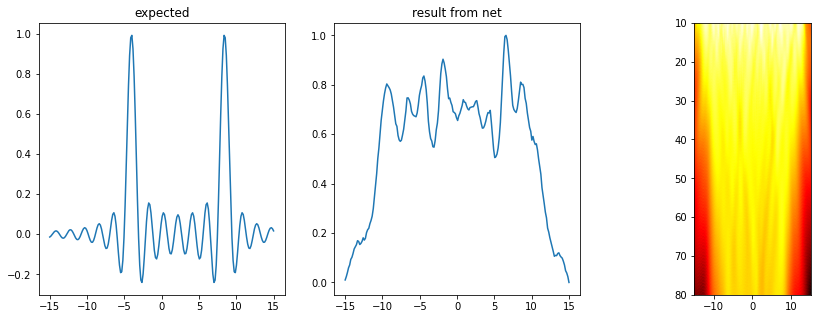

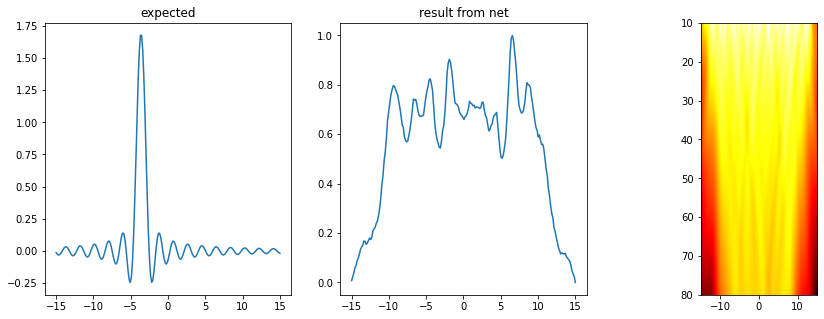

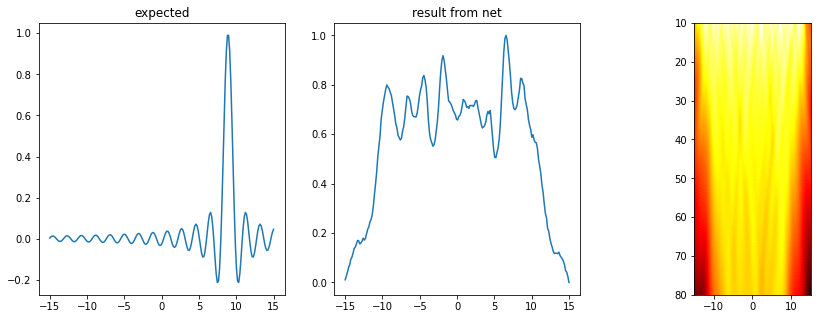

In [29]:
test_batch_delays(net,dataManager)
test_batch(net,dataManager)




In [44]:
print(len(dataManager.get_datasets()[0]))



10000


In [ ]:
datasets = dataManager.get_datasets()
train = datasets[0]
x_1,y_1 = train[20]
x_2,y_2 = train[5]
x_1 = x_1.reshape(1,-1,50).float()
x_2 = x_2.reshape(1,-1,50).float()
criterion = nn.MSELoss()
h_1 = net.init_hidden(1)
h_2 = net.init_hidden(1)
print(x_1.size())
print(criterion(x_1,x_2))
print(criterion(net(x_1,h_1)[0],net(x_2,h_2)[0]))
print(criterion(y_1,y_2))



In [ ]:
test_batch(net,dataManager)



In [ ]:
'''
copied from matlab, if want to use need to adjust

def calc_delay(focus,N_elements = 128, c = 1490, pitch = 0.218e-3):
    first = np.norm(focus)
    centers = np.arange(-num_elements/2+1,num_elements/2)
    centers = centers * pitch
    centers = [centers zeros(length(centers),2)];
    second = vecnorm(centers - focus,2,2)
    Delay = (first - second)/c
'''

